In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def readstarspec(filename):
    wv,flux = np.loadtxt(filename,skiprows=1,unpack=True)
    return wv,flux

In [3]:
const = 0.0143877735383    #hc/k

wv1=np.zeros(1024) #Wavelengths in meters up to 0.75 microns
wv2=np.zeros(1024) #Wavelength in meters starting at 0.75 microns
wvm1=np.zeros(1024) #Wavelengths in microns up to 0.75 microns
wvm2=np.zeros(1024) #Wavelength in microns starting at 0.75 microns
bb1=np.zeros(1024) #Planck function for x<0.75 microns
bb2=np.zeros(1024) #Planck function for x>0.75 microns
bb3=np.zeros(965) #Planck function for albedo wavelengths
pbb3 = np.zeros(965)
wavelengths = np.zeros(965)

zsolars = np.zeros(2)
dsnowalb = np.zeros(2)




In [4]:
def bbtemp(teff,wvref):
    sbk = 5.67e-8
    const = 0.0143877735383
    bbf = 1.0/wvref**5 * (1.0/(np.exp(const/(teff*wvref*1e-6))-1))
    return bbf

In [5]:
kwv,kdata = readstarspec("proximacen_hr.dat")

In [6]:
wv1[:] = kwv[0:1024]*1.0e-6
bb1[:] = kdata[0:1024]
wv2[:] = kwv[1024:]*1.0e-6
bb2[:] = kdata[1024:]

In [7]:
kwv2,kdata2 = readstarspec("proximacen.dat")

In [8]:
bb3[:] = kdata2[:]
wavelengths[:] = kwv2[:]

In [9]:
iwv,iceblend = np.loadtxt("iceblendmax.dat",unpack=True)

In [10]:
iceblend*=100.

In [11]:
      
a1 = 0.0
a2 = 0.0
for k in range(41): #Compute insolation-weighted albedo below 0.75 microns
    a1 = a1 + 0.5*(bb3[k]*iceblend[k]+bb3[k+1]*iceblend[k+1])*1.0e-6*(wavelengths[k+1]-wavelengths[k])

for k in range(41,964):
    a2 = a2 + 0.5*(bb3[k]*iceblend[k]+bb3[k+1]*iceblend[k+1])*1.0e-6*(wavelengths[k+1]-wavelengths[k])

print a1,a2
 

6.962535042173073e-08 5.91918644627241e-07


In [13]:
blackbody = bbtemp(3000,wavelengths)

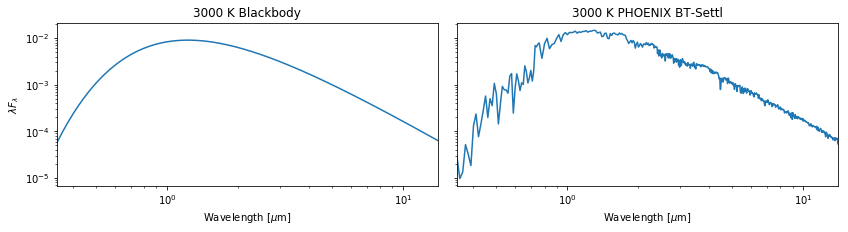

In [26]:
fig,axes = plt.subplots(1,2,figsize=(14,3),sharey=True,gridspec_kw={'wspace':0.05})
axes[1].plot(wavelengths,wavelengths*bb3)
axes[0].plot(wavelengths,wavelengths*blackbody)
#plt.plot(wavelengths,pbb3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[0].set_title("3000 K Blackbody")
axes[1].set_title("3000 K PHOENIX BT-Settl")
axes[0].set_xlabel("Wavelength [$\mu$m]")
axes[1].set_xlabel("Wavelength [$\mu$m]")
axes[0].set_ylabel("$\\lambda{F}_\\lambda$")
axes[0].set_xlim(wavelengths.min(),wavelengths.max())
axes[1].set_xlim(wavelengths.min(),wavelengths.max())
plt.savefig("3000k_spectra.png",bbox_inches='tight')
plt.savefig("3000k_spectra.pdf",bbox_inches='tight')

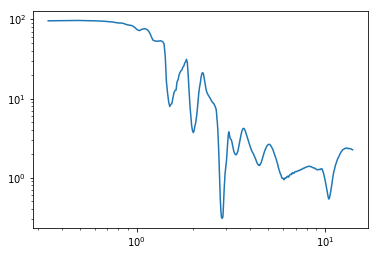

In [12]:
plt.plot(wavelengths,iceblend)
plt.xscale('log')
plt.yscale('log')

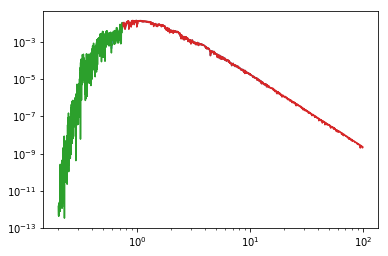

In [13]:
plt.plot(wavelengths,bb3)
plt.plot(wavelengths,pbb3)
plt.plot(wv1*1.0e6,bb1)
plt.plot(wv2*1.0e6,bb2)
plt.xscale('log')
plt.yscale('log')

In [14]:
   
z1 = 0.0
z2 = 0.0
for k in range(1023):    #Do a trapezoidal integration above and below 0.75 microns
    z1 = z1 + 0.5*(bb1[k]+bb1[k+1])*(wv1[k+1]-wv1[k])
    z2 = z2 + 0.5*(bb2[k]+bb2[k+1])*(wv2[k+1]-wv2[k])

z1 = z1 + 0.5*(bb1[1023]+bb2[0])*(wv2[0]-wv1[1023])

zdenom1 = 0.01/z1
zdenom2 = 0.01/z2

print zdenom1,zdenom2

a1 = zdenom1*a1 #Percent -> Decimal; normalization
a2 = zdenom2*a2

print a1,a2

13447966.205434104 691038.7757250677
0.9363193595129421 0.40903873551205006


In [15]:


znet = z1+z2

z1 = z1/znet
z2 = 1.0-z1

zsolar1 = z1
zsolar2 = z2

print "Energy fraction below 0.75 microns:",zsolar1
print "Energy fraction above 0.75 microns:",zsolar2

zsolars[0] = zsolar1
zsolars[1] = zsolar2

dsnowalb[0] = a1
dsnowalb[1] = a2

print "Snow albedo below 0.75 microns:",dsnowalb[0]
print "Snow albedo above 0.75 microns:",dsnowalb[1]
print "Overall snow albedo:",z1*dsnowalb[0]+z2*dsnowalb[1]

Energy fraction below 0.75 microns: 0.048874639809937566
Energy fraction above 0.75 microns: 0.9511253601900624
Snow albedo below 0.75 microns: 0.9363193595129421
Snow albedo above 0.75 microns: 0.40903873551205006
Overall snow albedo: 0.4348093860888528


In [16]:
starbbtemp = 5778.0
wvm1 = np.zeros(1024)
wvm2 = np.zeros(1024)

wavelengths = np.geomspace(0.3,100.0,num=6400)
bb3 = np.zeros(wavelengths.shape)

wmin = const/(starbbtemp*36.841361) #Wavelength where exponential term is <=1.0e-16
lwmin = np.log10(wmin)

hinge = np.log10(7.5e-7) #We care about amounts above and below 0.75 microns
dl1 = (hinge-lwmin)/1024.0
dl2 = (-4-hinge)/1024.0

for k in range(1024):
    wv1[k] = 10**(lwmin+(k-1)*dl1)
    wv2[k] = 10**(hinge+(k-1)*dl2)

for k in range(1024):
    wvm1[k] = (1.0e6 * wv1[k])**5
    wvm2[k] = (1.0e6 * wv2[k])**5
    
# const1 = 2*planckh*(cc**2)
const2 = const/starbbtemp
           
for k in range(1024): #Compute the Planck function
    bb1[k] = 1.0/wvm1[k] * 1.0/(np.exp(const2/wv1[k])-1) #const1/wv1(k)**5
    bb2[k] = 1.0/wvm2[k] * 1.0/(np.exp(const2/wv2[k])-1)
           
for k in range(len(wavelengths)): #Compute the Planck function for the wavelengths at which we have albedo data
    bb3[k] = 1.0/(wavelengths[k])**5 * 1.0/(np.exp(1.0e6*const2/wavelengths[k])-1)


In [17]:
z1 = 0
z2 = 0
z1 = np.trapz(bb3[wavelengths<=0.75],x=wavelengths[wavelengths<=0.75])
z2 = np.trapz(bb3[wavelengths>0.75],x=wavelengths[wavelengths>0.75])
znet = z1+z2
z1 = z1/znet
z2 = 1.0-z1
print z1,z2

0.5230360684951991 0.4769639315048009


In [18]:
print wvm1

[1.39411477e-06 1.41059374e-06 1.42726749e-06 ... 2.26408448e-01
 2.29084682e-01 2.31792550e-01]


In [19]:
   
z1 = 0.0
z2 = 0.0
for k in range(1023):    #Do a trapezoidal integration above and below 0.75 microns
    z1 = z1 + 0.5*(bb1[k]+bb1[k+1])*(wv1[k+1]-wv1[k])
    z2 = z2 + 0.5*(bb2[k]+bb2[k+1])*(wv2[k+1]-wv2[k])

z1 = z1 + 0.5*(bb1[1023]+bb2[0])*(wv2[0]-wv1[1023])

zdenom1 = 0.01/z1
zdenom2 = 0.01/z2

print zdenom1,zdenom2

a1 = zdenom1*a1 #Percent -> Decimal; normalization
a2 = zdenom2*a2

print a1,a2

110708.29607295051 127260.5135409453
103658.32087179419 52054.47953940239


In [20]:


znet = z1+z2

z1 = z1/znet
z2 = 1.0-z1

zsolar1 = z1
zsolar2 = z2

print "Energy fraction below 0.75 microns:",zsolar1
print "Energy fraction above 0.75 microns:",zsolar2

zsolars[0] = zsolar1
zsolars[1] = zsolar2

dsnowalb[0] = a1
dsnowalb[1] = a2

print "Snow albedo below 0.75 microns:",dsnowalb[0]
print "Snow albedo above 0.75 microns:",dsnowalb[1]
print "Overall snow albedo:",z1*dsnowalb[0]+z2*dsnowalb[1]

Energy fraction below 0.75 microns: 0.5347781238533965
Energy fraction above 0.75 microns: 0.4652218761466035
Snow albedo below 0.75 microns: 103658.32087179419
Snow albedo above 0.75 microns: 52054.47953940239
Overall snow albedo: 79651.08499076724


In [21]:
print wmin,hinge

6.75896800072e-08 -6.1249387366083


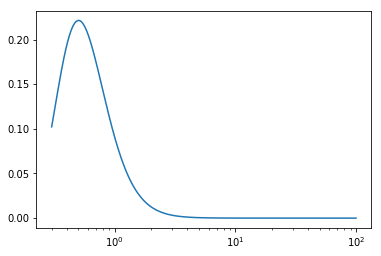

In [22]:
plt.plot(wavelengths,bb3)
plt.xscale('log')

In [23]:
def getpartition(temperature,wbottom=3.05994e-7):
    starbbtemp = temperature
    wvm1 = np.zeros(1024)
    wvm2 = np.zeros(1024)

    wavelengths = np.geomspace(wbottom,100.0,num=6400)
    bb3 = np.zeros(wavelengths.shape)

    #wmin = const/(starbbtemp*36.841361) #Wavelength where exponential term is <=1.0e-16
    wmin = wbottom
    lwmin = np.log10(wmin)

    hinge = np.log10(7.5e-7) #We care about amounts above and below 0.75 microns
    dl1 = (hinge-lwmin)/1024.0
    dl2 = (-4-hinge)/1024.0 #Go to 100 microns

    for k in range(1024):
        wv1[k] = 10**(lwmin+(k-1)*dl1)
        wv2[k] = 10**(hinge+(k-1)*dl2)

    for k in range(1024):
        wvm1[k] = (1.0e6 * wv1[k])**5
        wvm2[k] = (1.0e6 * wv2[k])**5
    
    const1 = 2*planckh*(cc**2)
    const2 = const/starbbtemp
           
    for k in range(1024): #Compute the Planck function
        bb1[k] = 1.0/wvm1[k] * 1.0/(np.exp(const2/wv1[k])-1) #const1/wv1(k)**5
        bb2[k] = 1.0/wvm2[k] * 1.0/(np.exp(const2/wv2[k])-1)
           
    for k in range(len(wavelengths)): #Compute the Planck function for the wavelengths at which we have albedo data
        bb3[k] = 1.0/(wavelengths[k])**5 * 1.0/(np.exp(1.0e6*const2/wavelengths[k])-1)
    
    z1 = 0.0
    z2 = 0.0
    for k in range(1023):    #Do a trapezoidal integration above and below 0.75 microns
        z1 = z1 + 0.5*(bb1[k]+bb1[k+1])*(wv1[k+1]-wv1[k])
        z2 = z2 + 0.5*(bb2[k]+bb2[k+1])*(wv2[k+1]-wv2[k])

    z1 = z1 + 0.5*(bb1[1023]+bb2[0])*(wv2[0]-wv1[1023])
    znet = z1+z2

    z1 = z1/znet
    z2 = 1.0-z1

    zsolar1 = z1
    zsolar2 = z2

    return zsolar1,zsolar2

In [24]:
nsteps = 20
t0 = 5778.0
f1,f2 = getpartition(t0)
if f1>0.517:
    lower = t0*0.8
    upper = t0
else:
    upper = t0*1.2
    lower = t0
for n in range(nsteps):
    mid = 0.5*(upper+lower)
    f1,f2 = getpartition(mid)
    if f1>0.517: #Too much flux in lower wavelengths; go to lower temperatures
        upper=mid
        lower=lower
    else: #Too little flux in lower wavelengths; go to higher temperatures
        upper=upper
        lower=mid
    print "%4.1f"%mid,f1,f2
    
    

NameError: global name 'planckh' is not defined

In [65]:
nsteps = 30
t0 = 5772.0
w0 = 300.0
f1,f2 = getpartition(t0,wbottom=w0*1.0e-9)
if f1>0.517: #Too much flux in lower wavelengths; increase minimum wavelength
    lower = w0
    upper = w0*1.5
else: #Too little flux in lower wavelenghts; reduce minimum wavelength
    upper = w0
    lower = w0*0.5
for n in range(nsteps):
    mid = 0.5*(upper+lower)
    f1,f2 = getpartition(t0,wbottom=mid*1.0e-9)
    if f1>0.517: #Too much flux in lower wavelengths; increase minimum wavelength
        upper=upper
        lower=mid
    else: #Too little flux in lower wavelengths; reduce minimum wavelength
        upper=mid
        lower=lower
    print "%3.9f"%mid,f1,f2
    
    

/home/adiv/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


375.000000000 0.4856280084216886 0.5143719915783114
337.500000000 0.5049958623391962 0.49500413766080376
318.750000000 0.5126002793039649 0.4873997206960351
309.375000000 0.5158938482338067 0.4841061517661933
304.687500000 0.5174159746181731 0.4825840253818269
307.031250000 0.5166652076562319 0.4833347923437681
305.859375000 0.5170431576934794 0.4829568423065206
306.445312500 0.5168548252693431 0.4831451747306569
306.152343750 0.5169491520117246 0.48305084798827536
306.005859375 0.5169961949702944 0.48300380502970564
305.932617188 0.5170196863594424 0.4829803136405576
305.969238281 0.5170079431719913 0.4829920568280087
305.987548828 0.5170020696979527 0.4829979303020473
305.996704102 0.5169991324908295 0.4830008675091705
305.992126465 0.5170006011335672 0.48299939886643284
305.994415283 0.5169998668219917 0.4830001331780083
305.993270874 0.5170002339802279 0.4829997660197721
305.993843079 0.5170000504017223 0.48299994959827774
305.994129181 0.51699995861201 0.48300004138799
305.9939861

In [66]:
getpartition(5772.0,wbottom=305.994e-9)

/home/adiv/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


(0.5170000000569389, 0.4829999999430611)

In [28]:
def plasimspec(starbbtemp=5772.0,wmin=3.16036116751e-7):
    wv2 = np.zeros(1024)
    wv1 = np.zeros(1024)
    wvm1 = np.zeros(1024)
    wvm2 = np.zeros(1024)
    bb1 = np.zeros(1024)
    bb2 = np.zeros(1024)

    const = 0.0143877735383
    
    #wmin = 3.05994e-7 # Set minimum wavelength to 305 nm; we don't include UV. 
                             # This produces zsolar1=0.517 at Teff=5772 K.
    lwmin = np.log10(wmin)
           
    hinge = np.log10(7.5e-7) #We care about amounts above and below 0.75 microns
    dl1 = (hinge-lwmin)/1024.0
    dl2 = (-4-hinge)/1024.0
           
    for k in range(1024):
        wv1[k] = 10**(lwmin + k*dl1)
        wv2[k] = 10**(hinge + k*dl2)
           
    for k in range(1024):
        wvm1[k] = (1.0e6 * wv1[k])**5
        wvm2[k] = (1.0e6 * wv2[k])**5
           
#            const1 = 2*planckh*(cc**2)
    const2 = const/starbbtemp
           
    for k in range(1024): #Compute the Planck function
        bb1[k] = 1.0/wvm1[k] * 1.0/(np.exp(const2/wv1[k])-1) #const1/wv1(k)**5
        bb2[k] = 1.0/wvm2[k] * 1.0/(np.exp(const2/wv2[k])-1)
#              write(nud,*) wv1(k),bb1(k),wv2(k),bb2(k)
         #The scaling and units don't actually matter, because we're going to normalize
    
    z1 = 0.0
    z2 = 0.0
    for k in range(1023):    #Do a trapezoidal integration above and below 0.75 microns
        z1 = z1 + 0.5*(bb1[k]+bb1[k+1])*(wv1[k+1]-wv1[k])
        z2 = z2 + 0.5*(bb2[k]+bb2[k+1])*(wv2[k+1]-wv2[k])
        
    z1 = z1 + 0.5*(bb1[1023]+bb2[0])*(wv2[0]-wv1[1023])
        
    zdenom1 = 0.01/z1
    zdenom2 = 0.01/z2
        
    znet = z1+z2
        
    z1 = z1/znet
    z2 = 1.0-z1
        
    zsolar1 = z1
    zsolar2 = z2
    return zsolar1,zsolar2

In [29]:
plasimspec()

(0.5203969150694923, 0.47960308493050774)

In [31]:
nsteps = 30
t0 = 5772.0
w0 = 300.0
f1,f2 = plasimspec(starbbtemp=t0,wmin=w0*1.0e-9)
if f1>0.517: #Too much flux in lower wavelengths; increase minimum wavelength
    lower = w0
    upper = w0*1.5
else: #Too little flux in lower wavelenghts; reduce minimum wavelength
    upper = w0
    lower = w0*0.5
for n in range(nsteps):
    mid = 0.5*(upper+lower)
    f1,f2 = plasimspec(starbbtemp=t0,wmin=mid*1.0e-9)
    if f1>0.517: #Too much flux in lower wavelengths; increase minimum wavelength
        upper=upper
        lower=mid
    else: #Too little flux in lower wavelengths; reduce minimum wavelength
        upper=mid
        lower=lower
    print "%3.9f"%mid,f1,f2
    
    

375.000000000 0.489187553925745 0.510812446074255
337.500000000 0.5084491326177559 0.49155086738224407
318.750000000 0.5160166187849352 0.4839833812150648
309.375000000 0.5192954827035478 0.48070451729645225
314.062500000 0.5176975819499329 0.4823024180500671
316.406250000 0.5168675306100916 0.4831324693899084
315.234375000 0.5172851581623484 0.48271484183765156
315.820312500 0.5170769955820402 0.48292300441795977
316.113281250 0.5169724259843134 0.48302757401568663
315.966796875 0.5170247514941376 0.4829752485058624
316.040039062 0.5169985989183572 0.4830014010816428
316.003417969 0.5170116777508569 0.4829883222491431
316.021728516 0.5170051389707809 0.48299486102921907
316.030883789 0.5170018691036156 0.48299813089638444
316.035461426 0.5170002340507482 0.48299976594925176
316.037750244 0.5169994164944933 0.4830005835055067
316.036605835 0.5169998252751058 0.4830001747248942
316.036033630 0.517000029663548 0.48299997033645203
316.036319733 0.516999927469482 0.483000072530518
316.0361